# Phase 3: Unsupervised Learning — Clustering for Travel Recommendations

**Group Members:**
- Abdulaziz Alasmari - 443100261
- Abdulaziz Almutairi - 443100720

**Objective:** Apply clustering to group destinations and show how clusters can improve or augment supervised recommendations. We will implement K-Means and DBSCAN, evaluate clusters (Silhouette Score, Within-Cluster Sum of Squares), compute BCubed Precision/Recall against the ground truth `travel_style` for evaluation, visualize results, and discuss integration with Phase 2 models.

**Note:** We explicitly remove the class label before clustering (but keep it aside for evaluation).

In [1]:
# 1. Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Clustering and evaluation
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Preprocessing and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds
np.random.seed(42)

print('Libraries imported')

Libraries imported


## 2. Load data and prepare features
We load the processed dataset from Phase 1, keep `travel_style` aside for evaluation, and remove it from the clustering input.

In [2]:
# Load processed data (from Dataset folder)
data_path = Path('../Dataset/travel_destinations_processed.csv')
df = pd.read_csv(data_path)

print('Loaded dataset:', df.shape)

# Keep the true labels aside for evaluation
true_labels = df['travel_style'].copy()

# Select features used previously (drop identifiers and target)
exclude = ['destination_id', 'destination_name', 'country', 'activities', 'travel_style', 'tourist_density']
X = df.drop(columns=[c for c in exclude if c in df.columns])

# If there are any non-numeric columns, one-hot encode them
non_numeric = X.select_dtypes(include=['object']).columns.tolist()
if len(non_numeric) > 0:
    X = pd.get_dummies(X, columns=non_numeric, drop_first=True)

print('Feature matrix shape (after encoding):', X.shape)

# Check missing values
print('Missing values in X:', X.isnull().sum().sum())

Loaded dataset: (60, 29)
Feature matrix shape (after encoding): (60, 49)
Missing values in X: 0


## 3. Preprocessing: scaling and dimensionality reduction (for visualization)
We scale features before clustering and use PCA to visualize clusters in 2D.

In [3]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print('PCA explained variance ratio:', pca.explained_variance_ratio_)

# Create a small dataframe for plotting
viz_df = pd.DataFrame({
    'pc1': X_pca[:, 0],
    'pc2': X_pca[:, 1],
    'true_label': true_labels
})

PCA explained variance ratio: [0.15661585 0.10427388]


## 4. K-Means Clustering: Elbow method, fit, and evaluate (Silhouette, inertia)

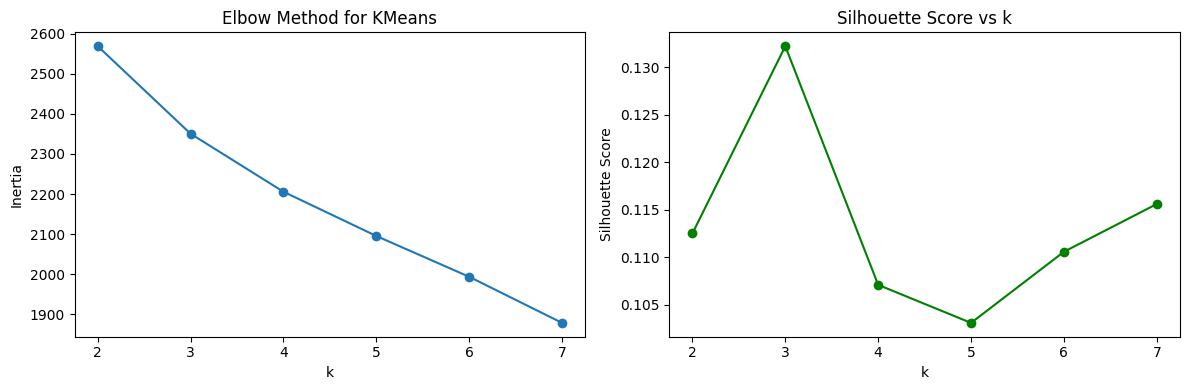

Chosen k (by silhouette): 3
KMeans inertia: 2350.3290346126955
KMeans silhouette: 0.1322127219153272


In [4]:
# Elbow method and silhouette for KMeans
inertias = []
sil_scores = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels_k))

# Plot elbow and silhouette
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, '-o', color='green')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

# Choose k (pick the k with max silhouette score for demonstration)
best_k = K_range[int(np.argmax(sil_scores))]
print('Chosen k (by silhouette):', best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
print('KMeans inertia:', kmeans.inertia_)
print('KMeans silhouette:', silhouette_score(X_scaled, kmeans_labels))

## 5. DBSCAN (density-based clustering) and evaluation
DBSCAN often finds clusters of varying density and can detect noise; it is a good complement to K-Means.

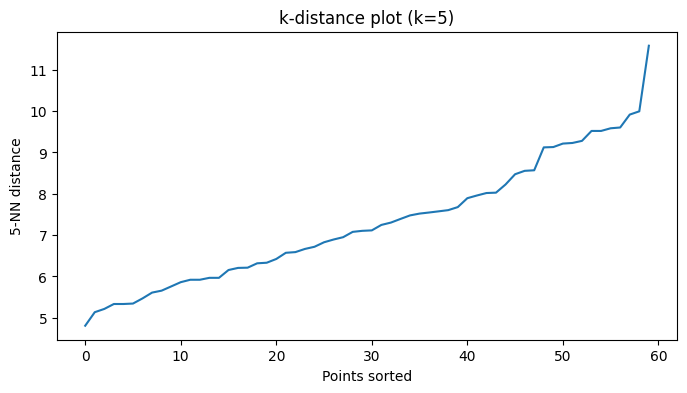

eps=0.5 -> clusters=0, silhouette=nan
eps=1.0 -> clusters=0, silhouette=nan
eps=1.5 -> clusters=0, silhouette=nan


In [5]:
# DBSCAN with a few eps choices
from sklearn.neighbors import NearestNeighbors

# Use k-distance plot to pick eps (optional)
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)
# sort distances to find knee
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(kdist)
plt.title('k-distance plot (k=5)')
plt.xlabel('Points sorted')
plt.ylabel('5-NN distance')
plt.show()

# Try DBSCAN with a couple of eps values
dbscan_eps = [0.5, 1.0, 1.5]
for eps in dbscan_eps:
    db = DBSCAN(eps=eps, min_samples=5)
    db_labels = db.fit_predict(X_scaled)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    if len(set(db_labels)) > 1 and n_clusters > 0:
        sil = silhouette_score(X_scaled, db_labels)
    else:
        sil = np.nan
    print(f'eps={eps} -> clusters={n_clusters}, silhouette={sil:.4f}')

# Choose a DBSCAN labeling for later comparison (pick eps=1.0)
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

## 6. BCubed Precision & Recall (for external evaluation using known travel_style labels)
BCubed evaluates clustering quality w.r.t. ground-truth classes; we compute BCubed precision and recall.

In [6]:
# Implement BCubed precision and recall
def bcubed_precision_recall(true_labels, cluster_labels):
    """Compute BCubed precision and recall.
    true_labels and cluster_labels are arrays-like of the same length.
    """
    n = len(true_labels)
    # Convert to numpy arrays
    true = np.array(true_labels)
    clust = np.array(cluster_labels)

    precisions = []
    recalls = []
    for i in range(n):
        # elements in same cluster as i
        same_cluster = (clust == clust[i])
        # elements with same true label as i
        same_true = (true == true[i])
        # intersection
        intersection = np.sum(same_cluster & same_true)
        if np.sum(same_cluster) > 0:
            precisions.append(intersection / np.sum(same_cluster))
        else:
            precisions.append(0.0)
        if np.sum(same_true) > 0:
            recalls.append(intersection / np.sum(same_true))
        else:
            recalls.append(0.0)

    return np.mean(precisions), np.mean(recalls)

# Evaluate KMeans clusters vs ground truth
km_p, km_r = bcubed_precision_recall(true_labels.values, kmeans_labels)
print(f"KMeans BCubed Precision: {km_p:.4f}, Recall: {km_r:.4f}")

# Evaluate DBSCAN clusters vs ground truth (ignore noise label -1 in BCubed calc works naturally)
db_p, db_r = bcubed_precision_recall(true_labels.values, dbscan_labels)
print(f"DBSCAN BCubed Precision: {db_p:.4f}, Recall: {db_r:.4f}")

KMeans BCubed Precision: 0.1214, Recall: 0.8331
DBSCAN BCubed Precision: 0.0622, Recall: 1.0000


## 7. Visualization of clusters (PCA scatter) and comparison with true labels

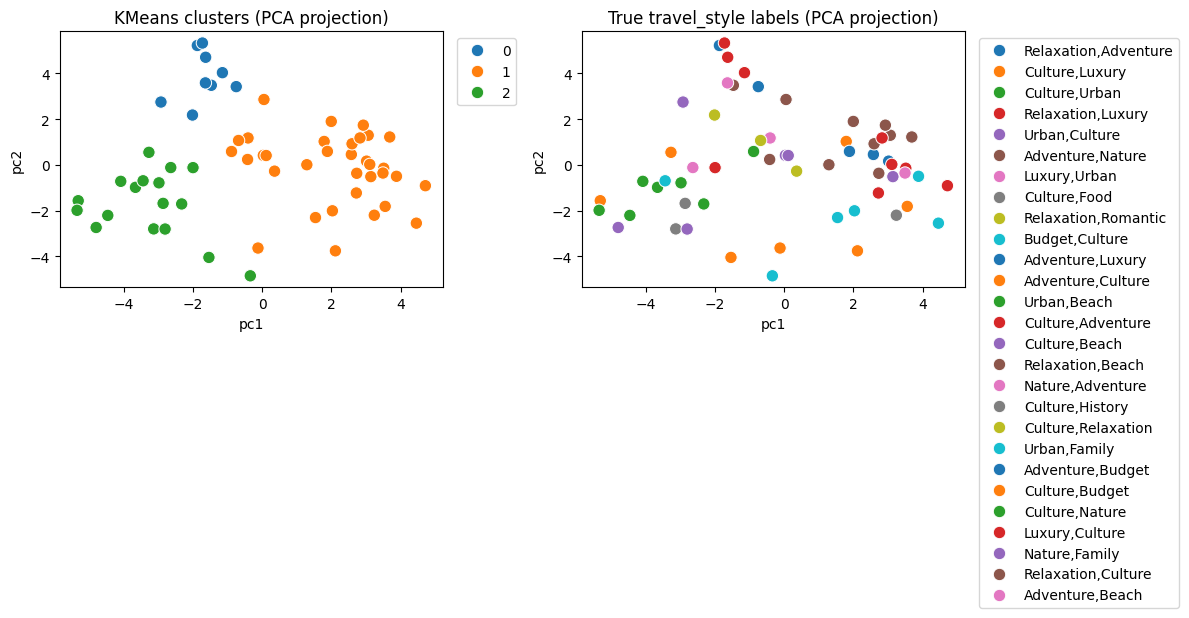

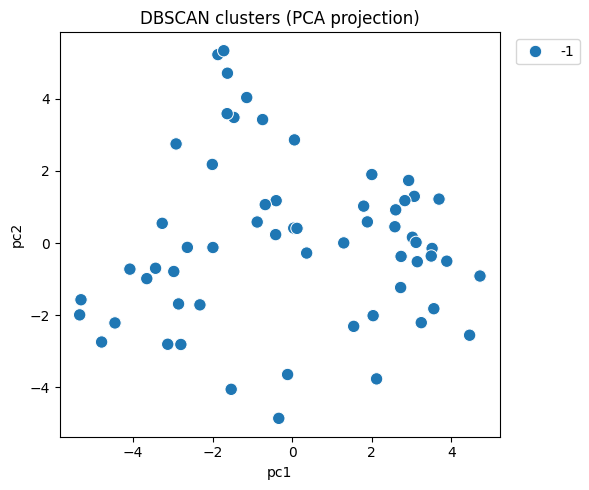

In [7]:
# Plot KMeans clusters on PCA
viz_df['kmeans_cluster'] = kmeans_labels
viz_df['dbscan_cluster'] = dbscan_labels

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(data=viz_df, x='pc1', y='pc2', hue='kmeans_cluster', palette='tab10', s=80)
plt.title('KMeans clusters (PCA projection)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.subplot(1,2,2)
sns.scatterplot(data=viz_df, x='pc1', y='pc2', hue='true_label', palette='tab10', s=80)
plt.title('True travel_style labels (PCA projection)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot DBSCAN
plt.figure(figsize=(6,5))
sns.scatterplot(data=viz_df, x='pc1', y='pc2', hue='dbscan_cluster', palette='tab10', s=80)
plt.title('DBSCAN clusters (PCA projection)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 8. Integration: Use clusters as features to augment supervised model
We demonstrate how adding cluster labels as a feature can improve classification performance (e.g., for SVM). This is a simple example using cross-validation to compare performance with and without cluster feature.

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Prepare dataframes for supervised example
X_supervised = X.copy()
# Without cluster
scores_no_cluster = cross_val_score(SVC(kernel='rbf', random_state=42), scaler.fit_transform(X_supervised), true_labels, cv=5, scoring='accuracy')

# With kmeans cluster as a new feature
X_with_cluster = X_supervised.copy()
X_with_cluster['kmeans_cluster'] = kmeans_labels
scores_with_cluster = cross_val_score(SVC(kernel='rbf', random_state=42), scaler.fit_transform(X_with_cluster), true_labels, cv=5, scoring='accuracy')

print('SVM accuracy without cluster (5-fold CV):', np.mean(scores_no_cluster))
print('SVM accuracy with kmeans cluster (5-fold CV):', np.mean(scores_with_cluster))

# Note: For reproducible production experiments, encode and persist clustering pipeline.

SVM accuracy without cluster (5-fold CV): 0.3
SVM accuracy with kmeans cluster (5-fold CV): 0.3


## 9. Conclusion and next steps
- KMeans provides compact clusters and is easy to interpret; DBSCAN can detect noise and varying-density clusters.
- Evaluate clusters with Silhouette, inertia, and BCubed for comparison against `travel_style`.
- Integration idea: use cluster labels as additional features for supervised models to improve recommendation personalization.

Next steps: refine preprocessing, tune clustering hyperparameters, and test cluster-augmented supervised pipelines on held-out data.